# 07 - SuperResolution and GAN's

## What is a GAN?
The Generative Adversarial Network was invented by Ian Goodfellow, where two networks play a game. In our case, we will build a 'crappifier' to make images worse, and the critic will try to determine which is fake and which is the original. This will help us achieve super-resolution

In [ ]:
# Run once per session
!pip install fastai

In [ ]:
from fastai.vision.all import *
from fastai.vision.gan import *

# Crappified data

Let's build a function first that will go through and 'crappify' some data:

In [ ]:
from PIL import ImageDraw, ImageFont

In [ ]:
def resize_to(img, targ_sz, use_min=False):
    w,h = img.size
    min_sz = (min if use_min else max)(w,h)
    ratio = targ_sz/min_sz
    return int(w*ratio),int(h*ratio)

In [ ]:
class Crappifier():
  "Quickly draw tesxt and numbers on an image"
  def __init__(self, path_lr, path_hr):
      self.path_lr = path_lr
      self.path_hr = path_hr              
      
  def __call__(self, fn):       
      dest = self.path_lr/fn.relative_to(self.path_hr)    
      dest.parent.mkdir(parents=True, exist_ok=True)
      img = Image.open(fn)
      targ_sz = resize_to(img, 96, use_min=True)
      img = img.resize(targ_sz, resample=Image.BILINEAR).convert('RGB')
      w,h = img.size
      q = random.randint(10,70)
      ImageDraw.Draw(img).text((random.randint(0,w//2),random.randint(0,h//2)), str(q), fill=(255,255,255))
      img.save(dest, quality=q)

And now let's get some data to work with. We'll use the `PETS` dataset:

In [ ]:
path = untar_data(URLs.PETS)

We'll make two folders, one for the low resolution (LR) and high resolution (HR) photos:

In [ ]:
path_hr = path/'images'
path_lr = path/'crappy'

Now let's generate our dataset!

In [ ]:
items = get_image_files(path_hr)

In [ ]:
parallel(Crappifier(path_lr, path_hr), items);

Let's take a look at one of our generated images:

In [ ]:
bad_im = get_image_files(path_lr)

In [ ]:
im1 = PILImage.create(items[0])
im2 = PILImage.create(bad_im[0])

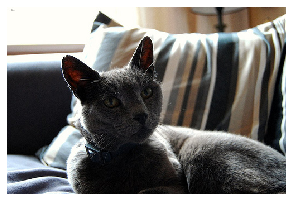

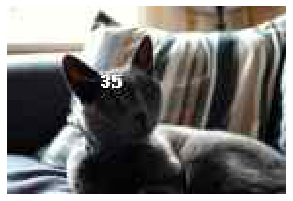

In [ ]:
im1.show(); im2.show(figsize=(5,5))

Great! We have some data now! Let's build the `DataBlock`

# DataBlock

In [ ]:
dblock = DataBlock(blocks=(ImageBlock, ImageBlock),
                   get_items=get_image_files,
                   get_y = lambda x: path_hr/x.name,
                   splitter=RandomSplitter(),
                   item_tfms=Resize(224),
                   batch_tfms=[*aug_transforms(max_zoom=2.),
                               Normalize.from_stats(*imagenet_stats)])

But for today's lesson, we'll go back to that progressive resizing technique we talked about. We want a function that can accept a `batch_size` and a `im_size`. Let's build that:

In [ ]:
def get_dls(bs:int, size:int):
  "Generates two `GAN` DataLoaders"
  dblock = DataBlock(blocks=(ImageBlock, ImageBlock),
                   get_items=get_image_files,
                   get_y = lambda x: path_hr/x.name,
                   splitter=RandomSplitter(),
                   item_tfms=Resize(size),
                   batch_tfms=[*aug_transforms(max_zoom=2.),
                               Normalize.from_stats(*imagenet_stats)])
  dls = dblock.dataloaders(path_lr, bs=bs, path=path)
  dls.c = 3 # For 3 channel image
  return dls

# Pre-Trained Generator

The goal of this model will be to generate our "Super Resolution" images (or to make an image look better)

In [ ]:
dls_gen = get_dls(32, 128)

On the left will be our 'crappified' image, and the right our original

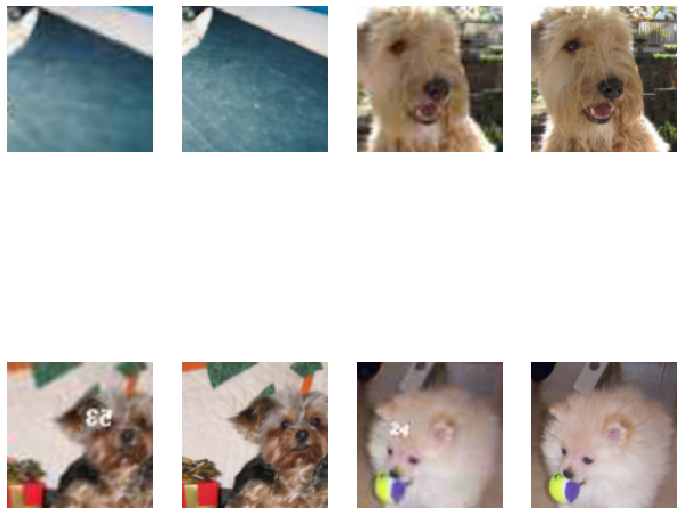

In [ ]:
dls_gen.show_batch(max_n=4, figsize=(12,12))

Now let's build some models (with recommended hyper-parameters)

In [ ]:
wd, y_range, loss_gen = 1e-3, (-3., 3.), MSELossFlat()

For our backbone, we'll use a resnet34

In [ ]:
bbone = resnet34
cfg = unet_config(blur=True, norm_type=NormType.Weight, self_attention=True,
                  y_range=y_range)

In [ ]:
def create_gen_learner():
  return unet_learner(dls_gen, bbone, loss_func=loss_gen,
                      config=cfg)

In [ ]:
learn_gen = create_gen_learner()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


Let's fit our model quickly (we don't need to train for very long)

In [ ]:
learn_gen.fit_one_cycle(2, pct_start=0.8, wd=wd)

epoch,train_loss,valid_loss,time
0,0.072490,0.056544,01:03
1,0.039271,0.039441,00:57


Let's unfreeze and fit a bit more!

In [ ]:
learn_gen.unfreeze()

In [ ]:
learn_gen.fit_one_cycle(3, slice(1e-6,1e-3), wd=wd)

epoch,train_loss,valid_loss,time
0,0.037209,0.037791,00:59
1,0.034622,0.035144,00:59
2,0.033383,0.034147,00:59


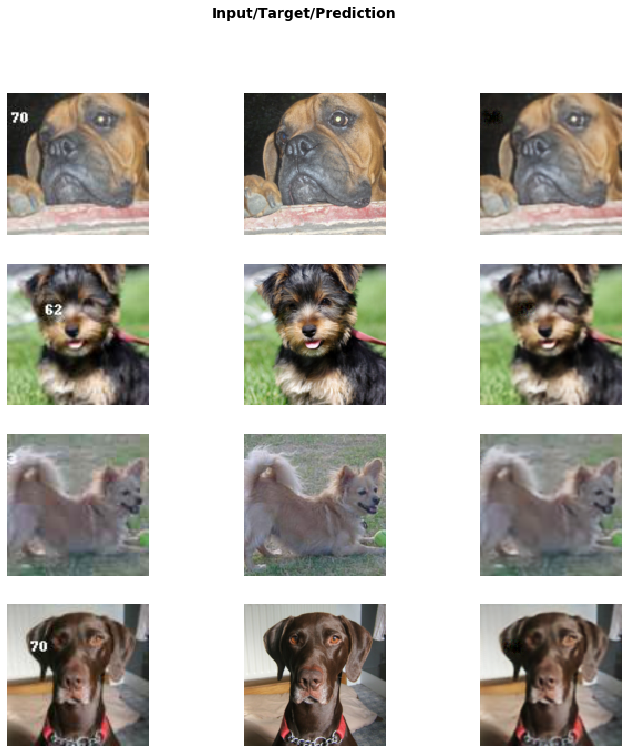

In [ ]:
learn_gen.show_results(max_n=4, figsize=(12,12))

In [ ]:
learn_gen.save('gen-pre2')

# Save the generated images

Now we need these generated images saved away so we can use them for our `critic` model. Let's do so:

In [ ]:
name_gen = 'image_gen'
path_gen = path/name_gen

In [ ]:
path_gen.mkdir(exist_ok=True)

In [ ]:
def save_preds(dl, learn):
  "Save away predictions"
  names = dl.dataset.items
  
  preds,_ = learn.get_preds(dl=dl)
  for i,pred in enumerate(preds):
      dec = dl.after_batch.decode((TensorImage(pred[None]),))[0][0]
      arr = dec.numpy().transpose(1,2,0).astype(np.uint8)
      Image.fromarray(arr).save(path_gen/names[i].name)

We'll want to get rid of any augmentation, `drop_last`, and `shuffle` from our training `DataLoader`:

In [ ]:
dl = dls_gen.train.new(shuffle=False, drop_last=False, 
                       after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])

Now let's look at what we're actually doing

In [ ]:
preds, _ = learn_gen.get_preds(dl=dl)

In [ ]:
preds[0].shape

torch.Size([3, 128, 128])

In [ ]:
preds[0][None].shape

torch.Size([1, 3, 128, 128])

In [ ]:
dec = dl.after_batch.decode((TensorImage(preds[0][None]),))[0][0]

In [ ]:
arr = dec.numpy().transpose(1,2,0)

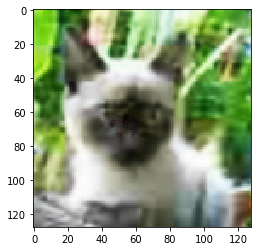

In [ ]:
plt.imshow(arr.astype(np.uint8))

Now let's go save it away. 

In [ ]:
save_preds(dl, learn_gen)

# Training the critic

Now let's build our critic model

In [ ]:
path_gen

Path('/root/.fastai/data/oxford-iiit-pet/image_gen')

In [ ]:
name_gen

'image_gen'

In [ ]:
# We have to do this because of a bug for right now
path_g = get_image_files(path/name_gen)
path_i = get_image_files(path/'images')
fnames = path_g + path_i

In [ ]:
fnames[0]

Path('/root/.fastai/data/oxford-iiit-pet/image_gen/english_setter_103.jpg')

In [ ]:
def get_crit_dls(fnames, bs:int, size:int):
  "Generate two `Critic` DataLoaders"
  splits = RandomSplitter(0.1)(fnames)
  dsrc = Datasets(fnames, tfms=[[PILImage.create], [parent_label, Categorize]],
                 splits=splits)
  tfms = [ToTensor(), Resize(size)]
  gpu_tfms = [IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)]
  return dsrc.dataloaders(bs=bs, after_item=tfms, after_batch=gpu_tfms)

In [ ]:
dls_crit = get_crit_dls(fnames, bs=32, size=128)

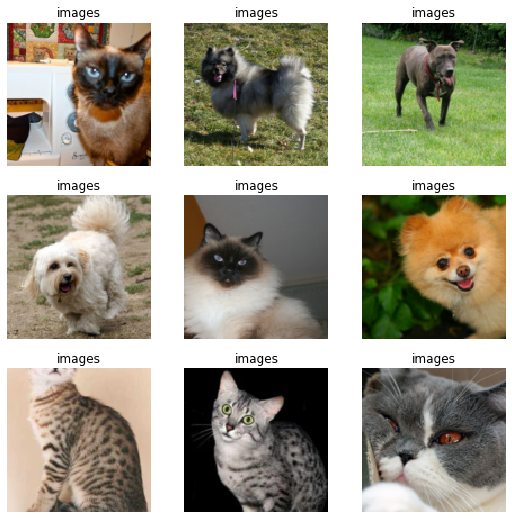

In [ ]:
dls_crit.show_batch()

In [ ]:
loss_crit = AdaptiveLoss(nn.BCEWithLogitsLoss())

In [ ]:
def create_crit_learner(dls, metrics):
  return Learner(dls, gan_critic(), metrics=metrics, loss_func=loss_crit)

In [ ]:
learn_crit = create_crit_learner(dls_crit, accuracy_thresh_expand)

And now let's fit!

In [ ]:
learn_crit.fit_one_cycle(6, 1e-3, wd=wd)

epoch,train_loss,valid_loss,accuracy_thresh_expand,time
0,0.688597,0.685605,0.566917,01:46
1,0.594720,0.486572,0.776391,01:47
2,0.069052,0.024454,0.993023,01:46
3,0.037225,0.039730,0.984541,01:46
4,0.010726,0.005761,0.998105,01:46
5,0.005903,0.005288,0.998376,01:46


In [ ]:
learn_crit.save('critic-pre2')

# The GAN

Now we'll combine the two models together into a gan

In [ ]:
dls_crit = get_crit_dls(fnames, bs=32, size=128)

In [ ]:
learn_crit = create_crit_learner(dls_crit, metrics=None).load('critic-pre2')

In [ ]:
learn_gen = create_gen_learner().load('gen-pre2')

The last thing to do is to define our GAN. We are going to do this from_learners, and specifiy which is the generator and which is the critic. The switcher is a callback that decides **when to switch from one to another**.

Here, we will do as many iterations of the discrimitor as needed until its loss is back to <0.65 then do an iteration of generator.

The loss function of the critic is learn_crit's loss function. We take the average on the batch of real (targ 1) and fake (targ 0) predictions.

The loss function of the generator is a weighted sum of the learn_crit.loss_func on the **fake** image batch with a target of 1, and learn_gen.loss_func is applied to the output and target, batch of fake and batch of super-res images.

In [ ]:
class GANDiscriminativeLR(Callback):
    "`Callback` that handles multiplying the learning rate by `mult_lr` for the critic."
    def __init__(self, mult_lr=5.): self.mult_lr = mult_lr

    def begin_batch(self):
        "Multiply the current lr if necessary."
        if not self.learn.gan_trainer.gen_mode and self.training: 
            self.learn.opt.set_hyper('lr', learn.opt.hypers[0]['lr']*self.mult_lr)

    def after_batch(self):
        "Put the LR back to its value if necessary."
        if not self.learn.gan_trainer.gen_mode: self.learn.opt.set_hyper('lr', learn.opt.hypers[0]['lr']/self.mult_lr)

Let's make our switcher and the `GANLearner`

In [ ]:
switcher = AdaptiveGANSwitcher(critic_thresh=.65)

In [ ]:
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.,50.), show_img=False, switcher=switcher,
                                 opt_func=partial(Adam, mom=0.), cbs=GANDiscriminativeLR(mult_lr=5.))

In [ ]:
lr = 1e-4

And fit!

In [ ]:
learn.fit(10, lr, wd=wd)

epoch,train_loss,valid_loss,gen_loss,crit_loss,time
0,1.127167,2.393311,2.393311,0.662887,01:56
1,1.170847,2.237427,2.237427,0.610548,01:55
2,1.330509,2.374964,2.374964,0.623188,01:53
3,1.329341,2.374464,2.374464,0.659515,01:51
4,1.382953,2.477902,2.477902,0.621288,01:50
5,1.361900,2.406281,2.406281,0.611732,01:51
6,1.366268,2.456414,2.456414,0.625404,01:51
7,1.359531,2.671926,2.671926,0.649263,01:51
8,1.274592,2.802825,2.802825,0.648941,01:52
9,1.352943,2.794070,2.794070,0.649443,01:52


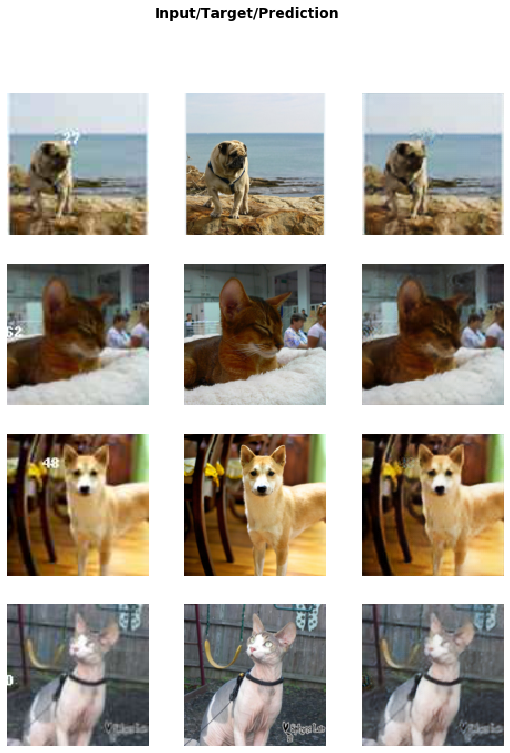

In [ ]:
learn.show_results(max_n=4)